### 3 Heat Pump with attached DHW

This notebook provides an example of how to run the heat pump with attached DHW controller. This system contains weather data, a house load, a heat pump with attached DHW, and a grid connection with fixed or agile prices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from datetime import datetime,tzinfo,timezone,timedelta
from collections import OrderedDict
from pathlib import Path
import importlib
current = os.path.abspath('')
parent = os.path.dirname(current)
sys.path.append(parent)


from matplotlib import pyplot as plt
import pandas as pd

In [3]:
import electrichouse as eh
from electrichouse.controllers import  PlanController,do_nothing_step_function
from electrichouse.components.inputs import (
    TempAndPVInputParams,
    TempAndPVComponent,
    HouseInflexibleLoadInputParams,
    HouseInflexibleLoadComponent,
)
from electrichouse.components.grid import (
    SingleRateTariffInputParams,
    SingleRateTariffComponent,
    OctopusAgileTariffComponent,
    GridInputParams,
    GridComponent,
)
from electrichouse.components.heating import HeatPumpComponent,HeatPumpInputParams, ThermostatDHWComponent, ThermostatDHWInputParams

importlib.reload(eh)

<module 'electrichouse' from '/Users/benaylott/projects/electrichouse/electrichouse/__init__.py'>

## Setup controller

In [4]:
%%time

dhw_average_daily_usage=6

def heat_pump_control(tandpv_outdoor_temp_C,dhw_demand_per_time_step_kW,dhw_thermostat_heat_demand_level_kW,**kwargs):
    return {
                "dhw_supply_active": True if dhw_demand_per_time_step_kW>dhw_thermostat_heat_demand_level_kW else False,
                "room_setpoint_temperature_C": 20.0,
                "outdoor_air_temperature_C": tandpv_outdoor_temp_C,
    }

def grid_control(hp_power_usage_kW,house_load_usage_kW,dhw_electrical_power_used_kW,dhw_external_heat_used_kW,hp_cop,**kwargs): 
    
    dhw_electrical_power_kW = dhw_electrical_power_used_kW
    
    heat_pump_dhp_electrical_power_kW = (
        dhw_external_heat_used_kW / hp_cop
    )
    
    return {
        "grid_requested_kw": -(
            hp_power_usage_kW
            + house_load_usage_kW
            + dhw_electrical_power_kW
            + heat_pump_dhp_electrical_power_kW
        )
    }

def dhw_control(hp_dhw_heat_available_kW,dhw_demand_per_time_step_kW,**kwargs):
    return {
        "max_external_heat_available_kW": hp_dhw_heat_available_kW,
        "heat_demand_request_kw": dhw_demand_per_time_step_kW
    }

plan=OrderedDict({
    "tandpv":{
        "input_params":TempAndPVInputParams(
            weather_data_filepath=Path(f"{os.path.abspath('')}/../data/weather_data.csv"),
            weather_data_year= 2014,
            pv_power_kW= 3,
        ),
        "control_params_init":{},
        "class":TempAndPVComponent,
        "step_function":do_nothing_step_function,
    },   
    "house_load":{
        "input_params":HouseInflexibleLoadInputParams(
            data_csv_filepath=Path(f"{os.path.abspath('')}/../data/loadm.csv"),
        ),
        "control_params_init":{},
        "class":HouseInflexibleLoadComponent,
        "step_function":do_nothing_step_function,
    },
    "hp":{
        "input_params":HeatPumpInputParams(
            max_modulation=0.0,
            max_heat_output_kw=8,
            building_heat_loss_coefficient_Q_kW_K=0.2,
        ),
        "control_params_init":{},
        "class":HeatPumpComponent,
        "step_function":heat_pump_control,
    },
    "dhw":{
        "input_params":ThermostatDHWInputParams(
            immersion_rating_kW= 2.5,
            max_heat_storage_kWh= 8,
            thermostat_level= 0.3,
        ),
        "control_params_init":{},
        "class":ThermostatDHWComponent,
        "step_function":dhw_control,
    },
    "grid":{
        "input_params":GridInputParams(
            min_kw=-3.68,
            max_kw= 23,
        ),
        "control_params_init":{},
        "class":GridComponent,
        "step_function":grid_control,
    },
    "tariff":{
        "input_params":SingleRateTariffInputParams(
            grid_import_price_pounds_per_kWh= 0.3,
            grid_export_price_pounds_per_kWh= 0.05,
        ),
        "control_params_init":{},
        "class":SingleRateTariffComponent,
        "step_function":do_nothing_step_function,
    },
})

controller =  PlanController(
        time_interval=timedelta(minutes=30),
        start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
        end_time=datetime(year=2022, month=1, day=1, tzinfo=timezone.utc),
        input_params={
            "dhw_demand_per_time_step_kW":2 * dhw_average_daily_usage / 48,
        },
        control_params_init={},
        plan=plan
    )


outputp=[]
for res in controller:
    outputp.append(res)

CPU times: user 1.2 s, sys: 31.9 ms, total: 1.23 s
Wall time: 1.24 s


## Analyse model results

In [5]:
outputpp=pd.DataFrame.from_records(outputp,index='timestamp')

(convert index to DatetimeIndex to access convenience methods)

In [6]:
outputpp.index=pd.DatetimeIndex(outputpp.index)

We can always check that energy balance is correct globally:

In [7]:
outputpp.head()

dhw_thermostat_heat_demand_level_kW  \
timestamp                                                        
2021-01-01 00:00:00+00:00                                11.20   
2021-01-01 00:30:00+00:00                                10.95   
2021-01-01 01:00:00+00:00                                10.70   
2021-01-01 01:30:00+00:00                                10.45   
2021-01-01 02:00:00+00:00                                10.20   

                           tandpv_pv_generation_kW  tandpv_outdoor_temp_C  \
timestamp                                                                   
2021-01-01 00:00:00+00:00                      0.0                   4.60   
2021-01-01 00:30:00+00:00                      0.0                   4.79   
2021-01-01 01:00:00+00:00                      0.0                   4.98   
2021-01-01 01:30:00+00:00                      0.0                   5.17   
2021-01-01 02:00:00+00:00                      0.0                   5.36   

                           house_load_usage_kW  hp_room_temperature_C  \
timestamp                                                               
2021-01-01 00:00:00+00:00               -0.242                   20.0   
2021-01-01 00:30:00+00:00               -0.300                   20.0   
2021-01-01 01:00:00+00:00               -1.318                   20.0   
2021-01-01 01:30:00+00:00               -0.776                   20.0   
2021-01-01 02:00:00+00:00               -0.894                   20.0   

                           hp_power_usage_kW  hp_outdoor_air_temp_C  \
timestamp                                                             
2021-01-01 00:00:00+00:00          -1.021491                   4.60   
2021-01-01 00:30:00+00:00          -1.000983                   4.79   
2021-01-01 01:00:00+00:00          -0.980711                   4.98   
2021-01-01 01:30:00+00:00          -0.960674                   5.17   
2021-01-01 02:00:00+00:00          -0.940873                   5.36   

                           hp_heat_demand_kW    hp_cop  hp_heat_demand_met  \
timestamp                                                                    
2021-01-01 00:00:00+00:00              3.080  3.015201                True   
2021-01-01 00:30:00+00:00              3.042  3.039012                True   
2021-01-01 01:00:00+00:00              3.004  3.063085                True   
2021-01-01 01:30:00+00:00              2.966  3.087417                True   
2021-01-01 02:00:00+00:00              2.928  3.112005                True   

                           hp_dhw_heat_available_kW  \
timestamp                                             
2021-01-01 00:00:00+00:00                  2.213933   
2021-01-01 00:30:00+00:00                  2.278225   
2021-01-01 01:00:00+00:00                  2.343254   
2021-01-01 01:30:00+00:00                  2.409014   
2021-01-01 02:00:00+00:00                  2.475497   

                           dhw_external_heat_used_kW  \
timestamp                                              
2021-01-01 00:00:00+00:00                        0.0   
2021-01-01 00:30:00+00:00                        0.0   
2021-01-01 01:00:00+00:00                        0.0   
2021-01-01 01:30:00+00:00                        0.0   
2021-01-01 02:00:00+00:00                        0.0   

                           dhw_electrical_power_used_kW  \
timestamp                                                 
2021-01-01 00:00:00+00:00                           0.0   
2021-01-01 00:30:00+00:00                           0.0   
2021-01-01 01:00:00+00:00                           0.0   
2021-01-01 01:30:00+00:00                           0.0   
2021-01-01 02:00:00+00:00                           0.0   

                           dhw_heat_demand_supplied_kW  dhw_stored_kWh  \
timestamp                                                                
2021-01-01 00:00:00+00:00                         0.25           7.875   
2021-01-01 00:30:00+00:00                         0.

In [8]:
outputpp["hp_dhw_power_usage_kW"] = outputpp["dhw_external_heat_used_kW"] / outputpp["hp_cop"]
pd.Series(outputpp[["house_load_usage_kW","hp_power_usage_kW","grid_supplied_kW","dhw_electrical_power_used_kW","hp_dhw_power_usage_kW"]].values.sum(axis=1)).sum(axis=0)

5.620504062164855e-16

Plot the DHW storage level throughout year...

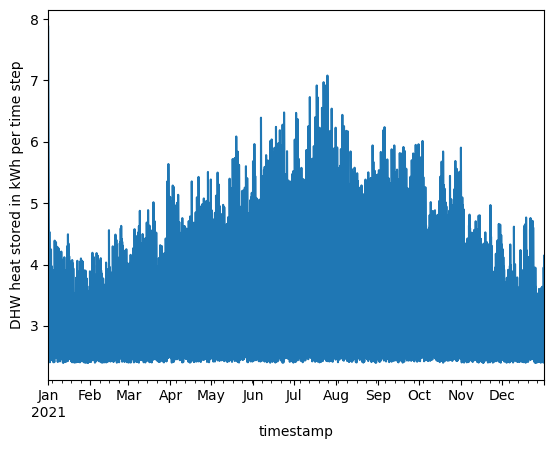

In [9]:
outputpp['dhw_stored_kWh'].plot()
plt.ylabel('DHW heat stored in kWh per time step')
plt.show()

<AxesSubplot: >

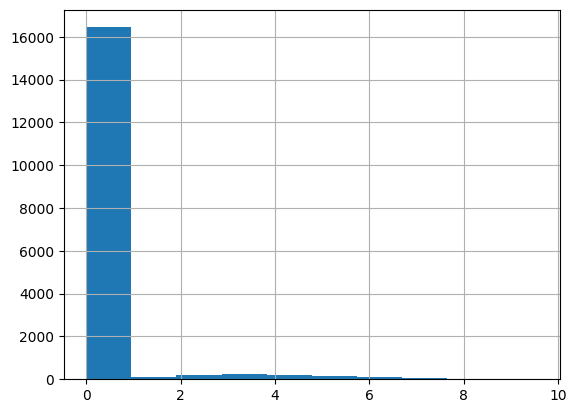

In [10]:
outputpp['dhw_external_heat_used_kW'].hist()

### Outdoor / indoor temperature

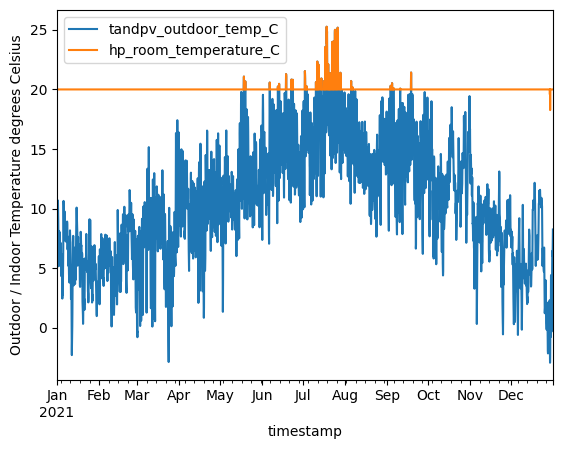

In [11]:
outputpp[["tandpv_outdoor_temp_C","hp_room_temperature_C"]].plot()

plt.ylabel('Outdoor / Indoor Temperature degrees Celsius')
plt.show()